[link text](https://)

Pediatric Pneumonia Image Classification with Deep Learning

**Business Problem**

In this project, the aim is to to build a deep neural network that trains on a large dataset for classification. In this case, we are using x-ray images of pediatric patients to identify whether or not they have pneumonia. The dataset comes from Kermany et al. on Mendeley.

In [33]:
!pip install lime

Adding Libraries that will be used for this project

In [35]:
import os
import glob
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

np.random.seed(123)

The data for this project was uploaded to Google Drive for ease of use and access. Therefore it was easily used in conjunction with Google Colab, that facilitated the use of GPUs for training.

In [18]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Location of Zip File
drive_path = '/gdrive/MyDrive/chest_xray.zip'
local_path = '/content'

In [19]:
!cp '{drive_path}' .


In [20]:
os.chdir(local_path)
!unzip -q 'chest_xray.zip'

In the outline below we are able to identify the number of images that we will be working with in our project. The outline specifies the type of image, which group (train, test, or validation) it is in, as well as the number of images in that particular group. 

In [21]:

# File Paths
path_train_pneumonia = '/content/chest_xray/train/PNEUMONIA'
path_train_normal = '/content/chest_xray/train/NORMAL'
path_test_pneumonia = '/content/chest_xray/test/PNEUMONIA'
path_test_normal = '/content/chest_xray/test/NORMAL'
path_val_pneumonia = '/content/chest_xray/val/PNEUMONIA'
path_val_normal = '/content/chest_xray/val/NORMAL'

# How many images in each set
print('Train Pneumonia', len(os.listdir(path_train_pneumonia)))
print('Train Normal', len(os.listdir(path_train_normal)))
print('Test Pneumonia', len(os.listdir(path_test_pneumonia)))
print('Test Normal', len(os.listdir(path_test_normal)))
print('Val Pneumonia', len(os.listdir(path_val_pneumonia)))
print('Val Normal', len(os.listdir(path_val_normal)))

Train Pneumonia 3875
Train Normal 1341
Test Pneumonia 390
Test Normal 234
Val Pneumonia 8
Val Normal 8


**Data Augmentation**

In this section, we will create some of the data generators that will be used for this project. Follwing will be some of the main points of image manipulation that we did for this project.

Image Alteration:


*   Sheer range set the sheer intensity to be at 0.2
*   Zoom range was set at 0.2, which regulates the range of random zoom on images
*  Horizontal flip was set at True, which randomly flips images horizontally
*  Image size was set at 150x150, which I felt was a good middle ground where the images are not too large and not too small
*  Color mode was set to 'grayscale'. Originally the images were in RGB, but it was set to grayscale to reflect the color of an actual xray in hopes to facilitate runtimes
*  Class mode was set to 'binary' since we are only considering two options: whether our program thinks that the x-ray displays pneumonia or if it is non-malignant.




In [22]:
# Create data generators
# Ensure class_mode is binary
# Use batch size based on our above findings
# Use a target size of 150x150 px for each image
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   horizontal_flip=False)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                                                    '/content/chest_xray/train',
                                                     target_size=(255, 255),
                                                     batch_size=5216,
                                                     color_mode='grayscale',
                                                     class_mode='binary')
test_generator = test_datagen.flow_from_directory(
                                                  '/content/chest_xray/test',
                                                   target_size=(255, 255),
                                                   batch_size=624,
                                                   color_mode='grayscale',
                                                   class_mode='binary')
                                                   
val_generator = val_datagen.flow_from_directory(
                                                '/content/chest_xray/val',
                                                 target_size=(255, 255),
                                                 batch_size=16,
                                                 color_mode='grayscale',
                                                 class_mode='binary')
                                                 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [23]:
# Create the data sets with the train/test/val splits
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

This allows us a glimpse in to what the first 20 images in our training set are labeled as. If we see below, the images reaffirm that normal x-rays (X_train[0]) and images with pneumonia (X_train[1]) are labeled 0 and 1, respectively.

In [24]:
# Check our y_train and which classes are which
print(y_train[:20])
print(y_train.shape)
train_generator.class_indices

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
(5216,)


{'NORMAL': 0, 'PNEUMONIA': 1}

In [36]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5216, 255, 255, 1)
(624, 255, 255, 1)
(16, 255, 255, 1)
(5216,)
(624,)
(16,)


**Image Preview**

We will look at the difference between our normal images and the images depicting pneumonia.

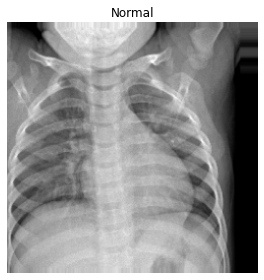

0.0


In [26]:
# What does a normal image look like?
plt.imshow(np.squeeze(X_train[0]), cmap='gray')
plt.axis('off')
plt.title('Normal')
plt.tight_layout()
plt.show()
# Check the class label ('Normal':0)
print(y_train[0])

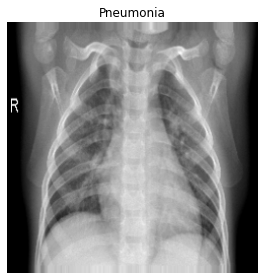

1.0


In [27]:
# What does a pneumonia xray look like?
plt.imshow(np.squeeze(X_train[1]), cmap='gray')
plt.axis('off')
plt.title('Pneumonia')
plt.tight_layout()
plt.show()
# Check class label ('Pneumonia':1)
print(y_train[1])

**Creating a visual of Class Imbalance**

As we can see from the image below, there is an imbalance between the number of images we have available for training normal x-ray images versus those x-rays depicting pneumonia. This will have to be something that we address within our models to improve accuracy.

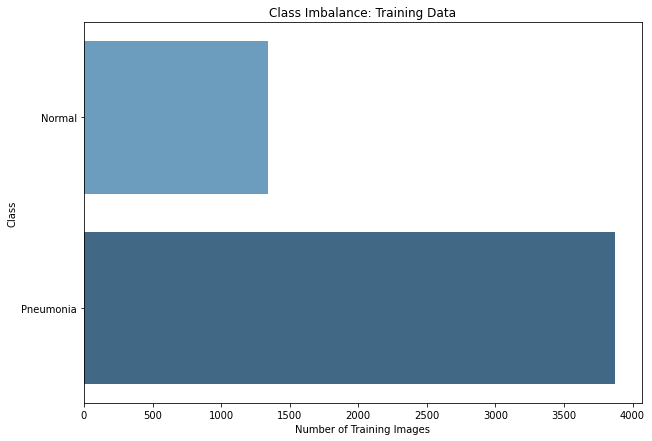

In [28]:
plt.figure(figsize=(10,7))
sns.barplot(x=[sum(y_train==0), sum(y_train==1)],
            y=['Normal', 'Pneumonia'],
            palette='Blues_d')
plt.title('Class Imbalance: Training Data')
plt.ylabel('Class')
plt.xlabel('Number of Training Images')
plt.show()

**Baseline Convolutional Neural Network**

This will be the baseline model that will serve as our benchmark, and our goal will be to improve from the metrics derived from this model.


In [39]:
baseline = models.Sequential()

baseline.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Conv2D(64, (3, 3), activation='relu'))
baseline.add(MaxPooling2D(2, 2))

baseline.add(Conv2D(128, (3, 3), activation='relu'))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Conv2D(256, (3, 3), activation='relu'))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Flatten())
baseline.add(Dense(500, activation='relu'))
baseline.add(Dense(1, activation='sigmoid'))

baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])
baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 256)      

In [41]:
history = baseline.fit(X_train,
                       y_train,
                       epochs=5,
                       batch_size=32,
                       validation_data=(X_val, y_val))


Epoch 1/5
163/163 [==============================] - 6s 38ms/step - loss: 0.2687 - acc: 0.8913 - val_loss: 0.3315 - val_acc: 0.8750
Epoch 2/5
163/163 [==============================] - 6s 36ms/step - loss: 0.1677 - acc: 0.9329 - val_loss: 0.4304 - val_acc: 0.7500
Epoch 3/5
163/163 [==============================] - 6s 36ms/step - loss: 0.1374 - acc: 0.9480 - val_loss: 0.3239 - val_acc: 0.8750
Epoch 4/5
163/163 [==============================] - 6s 36ms/step - loss: 0.1137 - acc: 0.9582 - val_loss: 0.3277 - val_acc: 0.8750
Epoch 5/5
163/163 [==============================] - 6s 36ms/step - loss: 0.0962 - acc: 0.9626 - val_loss: 0.3317 - val_acc: 0.8125


In [42]:
def evaluate_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """

  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['acc', 'val_acc'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  y_hat_test = results.model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test < thresh).astype(np.int)
  y_true = y_test.astype(np.int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predictions')
  plt.ylabel('Actuals')
  plt.title('Model Confusion Matrix')
  plt.show()

  print(classification_report(y_true, y_pred))
  print('\n')

  test_loss, test_acc = results.model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

  

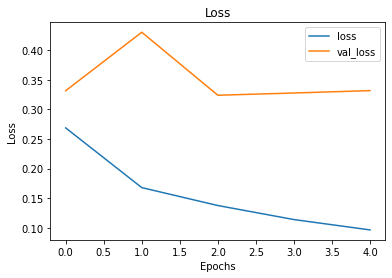

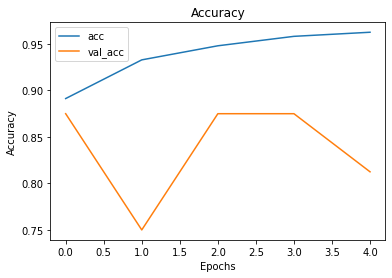

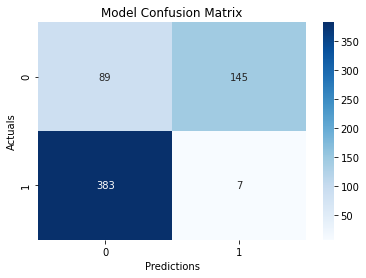

              precision    recall  f1-score   support

           0       0.19      0.38      0.25       234
           1       0.05      0.02      0.03       390

    accuracy                           0.15       624
   macro avg       0.12      0.20      0.14       624
weighted avg       0.10      0.15      0.11       624



20/20 [==============================] - 0s 14ms/step - loss: 0.5966 - acc: 0.8462
Test Loss: 0.596593976020813
Test Acc: 0.8461538553237915


In [43]:

evaluate_results(history)


What we can gather from the model is that when we look at the true values in the confusion matrix, 89 images where classified as Normal when they were in fact normal and 7 images where classified as exhibiting pneumonia which were correct. That puts our recall levels at 38% and 2% respectively. We will hopefully improve from these benchmark values in the subsequent model below.

**Model 1 - Using Class Weights**

In this model, we will attempt to improve our results by setting up class weights for our first model. The hope is that by setting these weights we can help remedy the imbalance in the data that we saw above. As a reminder our training data held 1341 images of normal x-rays and 3875 images of x-rays with pneumonia.

In [48]:
# Set up out class weights
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
weights_dict = dict(zip(np.unique(y_train), weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [49]:
model_1 = models.Sequential()

model_1.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(2, 2))

model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(256, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(500, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))


model_1.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['acc'])

In [50]:
model_1.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 256)      

In [51]:
results_1 = model_1.fit(X_train,
                   y_train,
                   epochs=5,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   class_weight=weights_dict)


Epoch 1/5
163/163 [==============================] - 7s 37ms/step - loss: 0.4065 - acc: 0.7770 - val_loss: 0.4541 - val_acc: 0.7500
Epoch 2/5
163/163 [==============================] - 6s 36ms/step - loss: 0.2038 - acc: 0.9164 - val_loss: 0.5243 - val_acc: 0.7500
Epoch 3/5
163/163 [==============================] - 6s 36ms/step - loss: 0.1623 - acc: 0.9381 - val_loss: 0.4010 - val_acc: 0.8750
Epoch 4/5
163/163 [==============================] - 6s 36ms/step - loss: 0.1231 - acc: 0.9519 - val_loss: 0.4150 - val_acc: 0.7500
Epoch 5/5
163/163 [==============================] - 6s 36ms/step - loss: 0.1066 - acc: 0.9574 - val_loss: 0.4363 - val_acc: 0.8125


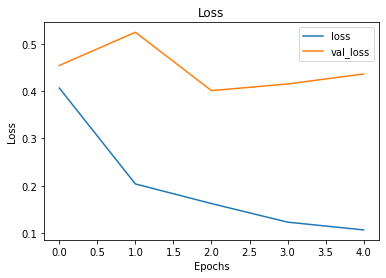

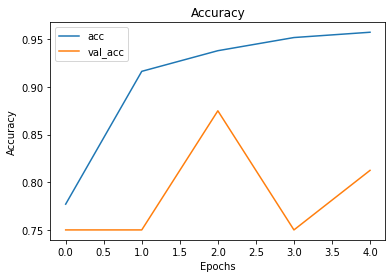

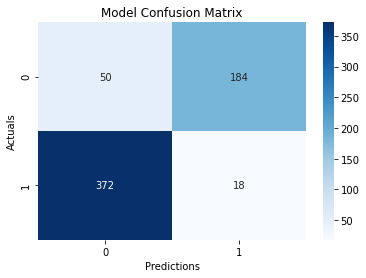

              precision    recall  f1-score   support

           0       0.12      0.21      0.15       234
           1       0.09      0.05      0.06       390

    accuracy                           0.11       624
   macro avg       0.10      0.13      0.11       624
weighted avg       0.10      0.11      0.10       624



20/20 [==============================] - 0s 14ms/step - loss: 0.3157 - acc: 0.8910
Test Loss: 0.315725713968277
Test Acc: 0.8910256624221802


In [52]:
evaluate_results(results_1)

**Model 2 Implementing RMSprop Optimizer**


Using RMSprop as the optimizer. RMSprop takes away the need to adjust learning rate, and does it automatically. More so, RMSProp choses a different learning rate for each parameter.

In [53]:
model_2 = models.Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(2, 2))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(2, 2))

model_2.add(Conv2D(256, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(2, 2))


model_2.add(Flatten())
model_2.add(Dense(500, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))


model_2.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [54]:
model_2.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 256)      

In [55]:
results_2 = model_2.fit(X_train,
                   y_train,
                   epochs=5,
                   batch_size=32,
                   validation_data=(X_val, y_val))

Epoch 1/5
163/163 [==============================] - 7s 39ms/step - loss: 0.6200 - acc: 0.7818 - val_loss: 0.4228 - val_acc: 0.7500
Epoch 2/5
163/163 [==============================] - 6s 39ms/step - loss: 0.2349 - acc: 0.9133 - val_loss: 0.4257 - val_acc: 0.7500
Epoch 3/5
163/163 [==============================] - 6s 38ms/step - loss: 0.1768 - acc: 0.9354 - val_loss: 0.2614 - val_acc: 0.9375
Epoch 4/5
163/163 [==============================] - 6s 39ms/step - loss: 0.1360 - acc: 0.9530 - val_loss: 0.9488 - val_acc: 0.6875
Epoch 5/5
163/163 [==============================] - 6s 38ms/step - loss: 0.1153 - acc: 0.9592 - val_loss: 0.1586 - val_acc: 0.9375


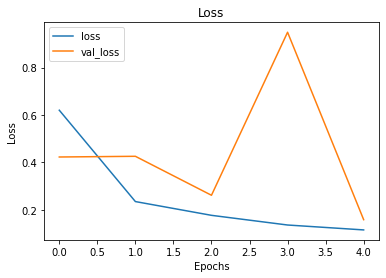

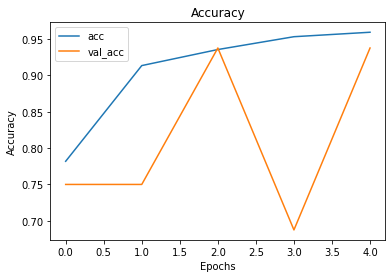

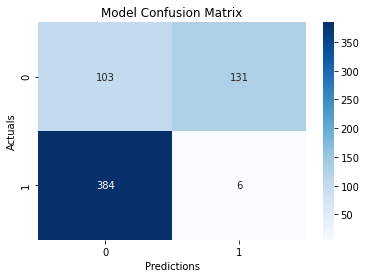

              precision    recall  f1-score   support

           0       0.21      0.44      0.29       234
           1       0.04      0.02      0.02       390

    accuracy                           0.17       624
   macro avg       0.13      0.23      0.15       624
weighted avg       0.11      0.17      0.12       624



20/20 [==============================] - 0s 14ms/step - loss: 0.6377 - acc: 0.8253
Test Loss: 0.6376817226409912
Test Acc: 0.8253205418586731


In [56]:
evaluate_results(results_2)


With weights

In [57]:
model_2w = models.Sequential()

model_2w.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
model_2w.add(MaxPooling2D((2, 2)))

model_2w.add(Conv2D(64, (3, 3), activation='relu'))
model_2w.add(MaxPooling2D(2, 2))

model_2w.add(Conv2D(128, (3, 3), activation='relu'))
model_2w.add(MaxPooling2D(2, 2))

model_2w.add(Conv2D(256, (3, 3), activation='relu'))
model_2w.add(MaxPooling2D(2, 2))


model_2w.add(Flatten())
model_2w.add(Dense(500, activation='relu'))
model_2w.add(Dense(1, activation='sigmoid'))


model_2w.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [58]:
model_2w.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 256)      

In [59]:
results_2w = model_2w.fit(X_train,
                   y_train,
                   epochs=5,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   class_weight=weights_dict)

Epoch 1/5
163/163 [==============================] - 7s 39ms/step - loss: 0.6225 - acc: 0.7214 - val_loss: 0.4760 - val_acc: 0.7500
Epoch 2/5
163/163 [==============================] - 6s 39ms/step - loss: 0.2671 - acc: 0.9080 - val_loss: 0.4979 - val_acc: 0.6875
Epoch 3/5
163/163 [==============================] - 6s 39ms/step - loss: 0.2073 - acc: 0.9270 - val_loss: 1.3235 - val_acc: 0.6875
Epoch 4/5
163/163 [==============================] - 6s 39ms/step - loss: 0.1585 - acc: 0.9421 - val_loss: 0.2590 - val_acc: 0.8125
Epoch 5/5
163/163 [==============================] - 6s 39ms/step - loss: 0.1433 - acc: 0.9517 - val_loss: 0.2815 - val_acc: 0.8125


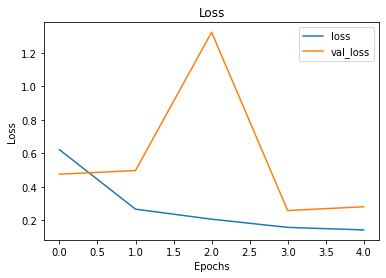

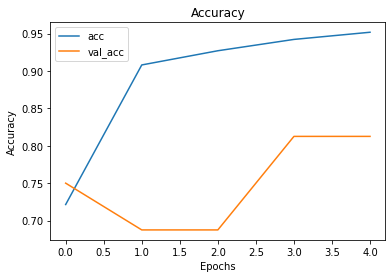

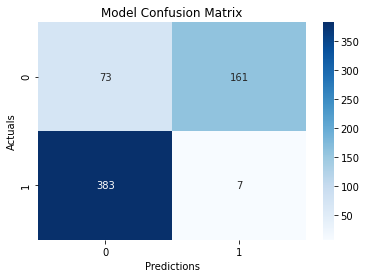

              precision    recall  f1-score   support

           0       0.16      0.31      0.21       234
           1       0.04      0.02      0.03       390

    accuracy                           0.13       624
   macro avg       0.10      0.16      0.12       624
weighted avg       0.09      0.13      0.10       624



20/20 [==============================] - 0s 14ms/step - loss: 0.4651 - acc: 0.8718
Test Loss: 0.46508392691612244
Test Acc: 0.8717948794364929


In [60]:
evaluate_results(results_2w)

These two models have improved from our levels of normal, x-rays detected but we are still dealing with a lot of fluctuation. We will try to implement additional methods to see if we can improve from this model using relu and weights.


**Model 3 Using EarlyStopping and ReduceLROnPlateau**

We will use the EarlyStopping and ReduceLRonPlateau in an attempt to reduce some of the overfitting that we have been seeing in our models.

In [61]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks = [ early, learning_rate_reduction]

In [62]:
model_3 = models.Sequential()

model_3.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(2, 2))

model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(2, 2))

model_3.add(Conv2D(256, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(2, 2))

model_3.add(Flatten())
model_3.add(Dense(500, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))


model_3.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [63]:
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 256)      

In [64]:
results_3 = model_3.fit(X_train,
                   y_train,
                   epochs=5,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   callbacks=callbacks,
                   class_weight=weights_dict)


Epoch 1/5
163/163 [==============================] - 7s 39ms/step - loss: 0.6262 - acc: 0.7669 - val_loss: 0.5321 - val_acc: 0.8125
Epoch 2/5
163/163 [==============================] - 6s 39ms/step - loss: 0.2416 - acc: 0.9120 - val_loss: 0.3530 - val_acc: 0.8750
Epoch 3/5
163/163 [==============================] - 6s 38ms/step - loss: 0.1919 - acc: 0.9277 - val_loss: 0.6775 - val_acc: 0.6250
Epoch 4/5
163/163 [==============================] - 6s 39ms/step - loss: 0.1595 - acc: 0.9419 - val_loss: 0.2171 - val_acc: 0.9375
Epoch 5/5
163/163 [==============================] - 6s 39ms/step - loss: 0.1248 - acc: 0.9561 - val_loss: 0.1834 - val_acc: 0.9375


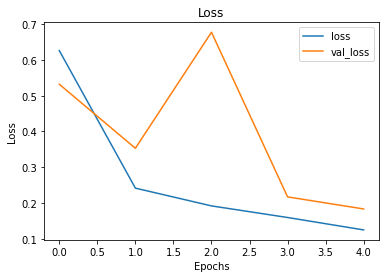

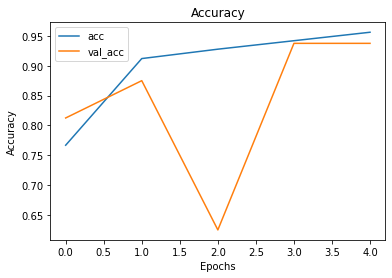

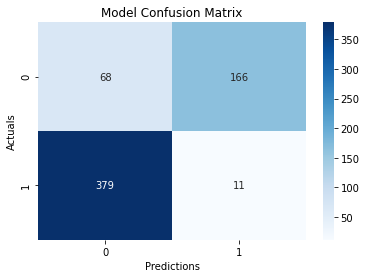

              precision    recall  f1-score   support

           0       0.15      0.29      0.20       234
           1       0.06      0.03      0.04       390

    accuracy                           0.13       624
   macro avg       0.11      0.16      0.12       624
weighted avg       0.10      0.13      0.10       624



20/20 [==============================] - 0s 14ms/step - loss: 0.4060 - acc: 0.8734
Test Loss: 0.40599626302719116
Test Acc: 0.8733974099159241


In [65]:
evaluate_results(results_3)


**Model 4 - Changing more layers**

We will take the most promising models from above and add additional layers to see if this improves our performance. The plan will be to include an additional layer to model 3.


In [66]:
model_4 = models.Sequential()

model_4.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(2, 2))

model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(2, 2))

model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(2, 2))

model_4.add(Conv2D(256, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(2, 2))


model_4.add(Flatten())
model_4.add(Dense(500, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))


model_4.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [67]:
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 128)      

In [68]:
results_4 = model_4.fit(X_train,
                        y_train,
                   epochs=5,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/5
163/163 [==============================] - 7s 36ms/step - loss: 0.4876 - acc: 0.7759 - val_loss: 0.4603 - val_acc: 0.8750
Epoch 2/5
163/163 [==============================] - 6s 35ms/step - loss: 0.2447 - acc: 0.9055 - val_loss: 0.5482 - val_acc: 0.7500
Epoch 3/5
163/163 [==============================] - 6s 35ms/step - loss: 0.1900 - acc: 0.9227 - val_loss: 0.3269 - val_acc: 0.8125
Epoch 4/5
163/163 [==============================] - 6s 35ms/step - loss: 0.1714 - acc: 0.9383 - val_loss: 0.3552 - val_acc: 0.8125
Epoch 5/5
163/163 [==============================] - 6s 34ms/step - loss: 0.1470 - acc: 0.9454 - val_loss: 0.3113 - val_acc: 0.8750


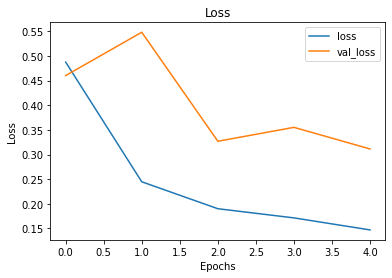

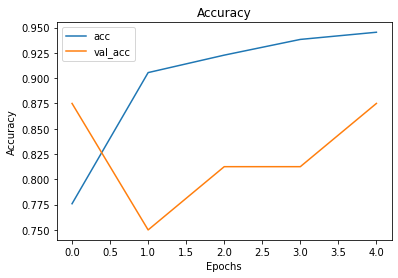

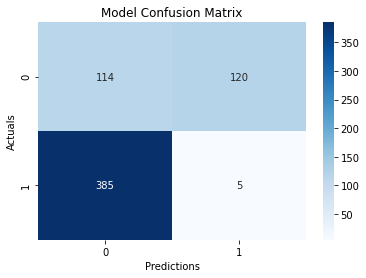

              precision    recall  f1-score   support

           0       0.23      0.49      0.31       234
           1       0.04      0.01      0.02       390

    accuracy                           0.19       624
   macro avg       0.13      0.25      0.17       624
weighted avg       0.11      0.19      0.13       624



20/20 [==============================] - 0s 13ms/step - loss: 0.7164 - acc: 0.8093
Test Loss: 0.716413676738739
Test Acc: 0.8092948794364929


In [69]:
evaluate_results(results_4)


**Model 5 Adding Dropout layers**

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

In [70]:
model_5 = models.Sequential()

model_5.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
model_5.add(MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.2))

model_5.add(Conv2D(64, (3, 3), activation='relu'))
model_5.add(MaxPooling2D(2, 2))
model_5.add(layers.Dropout(0.2))

model_5.add(Conv2D(128, (3, 3), activation='relu'))
model_5.add(MaxPooling2D(2, 2))
model_5.add(layers.Dropout(0.2))

model_5.add(Conv2D(256, (3, 3), activation='relu'))
model_5.add(MaxPooling2D(2, 2))
model_5.add(layers.Dropout(0.2))

model_5.add(Flatten())
model_5.add(Dense(500, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))


model_5.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [71]:
model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 60, 60, 128)      

In [72]:
results_5 = model_5.fit(X_train,
                        y_train,
                   epochs=5,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/5
163/163 [==============================] - 8s 43ms/step - loss: 0.8854 - acc: 0.6597 - val_loss: 0.4959 - val_acc: 0.8750
Epoch 2/5
163/163 [==============================] - 7s 42ms/step - loss: 0.3205 - acc: 0.8652 - val_loss: 0.4675 - val_acc: 0.6875
Epoch 3/5
163/163 [==============================] - 7s 42ms/step - loss: 0.2533 - acc: 0.9147 - val_loss: 0.3960 - val_acc: 0.7500
Epoch 4/5
163/163 [==============================] - 7s 42ms/step - loss: 0.2093 - acc: 0.9344 - val_loss: 0.5098 - val_acc: 0.7500
Epoch 5/5
163/163 [==============================] - 7s 42ms/step - loss: 0.1632 - acc: 0.9413 - val_loss: 0.3508 - val_acc: 0.7500


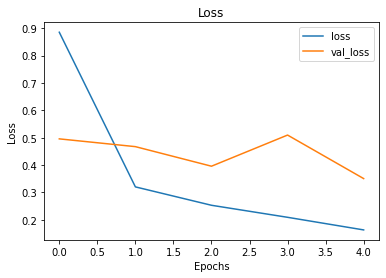

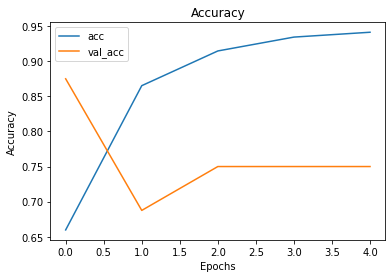

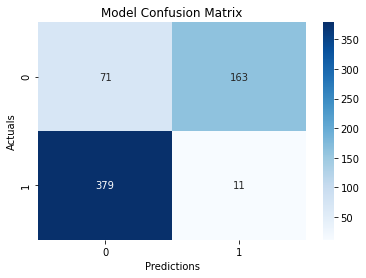

              precision    recall  f1-score   support

           0       0.16      0.30      0.21       234
           1       0.06      0.03      0.04       390

    accuracy                           0.13       624
   macro avg       0.11      0.17      0.12       624
weighted avg       0.10      0.13      0.10       624



20/20 [==============================] - 0s 14ms/step - loss: 0.3396 - acc: 0.8686
Test Loss: 0.3395710587501526
Test Acc: 0.8685897588729858


In [73]:
evaluate_results(results_5)

**Model 6 Keeping Dropout and changing layers**

In this model we will increase the Dropout amounts and also reduce the number of layers. We are trying to work on reducing some of the overfitting we saw in the other models to improve performance.



In [127]:
model_6 = models.Sequential()

model_6.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(255, 255, 1)))
model_6.add(MaxPooling2D((2, 2)))
model_6.add(layers.Dropout(0.2))

model_6.add(Conv2D(32, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(2, 2))
model_6.add(layers.Dropout(0.2))

model_6.add(Conv2D(64, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(2, 2))
model_6.add(layers.Dropout(0.2))


model_6.add(Flatten())
model_6.add(Dense(500, activation='relu'))
model_6.add(Dense(128, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))


model_6.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [128]:
model_6.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 253, 253, 32)      320       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 60, 60, 64)      

In [129]:
results_6 = model_6.fit(X_train,
                        y_train,
                   epochs=5,
                   batch_size=16,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/5
261/261 [==============================] - 7s 24ms/step - loss: 0.7638 - acc: 0.7464 - val_loss: 0.8650 - val_acc: 0.6839
Epoch 2/5
261/261 [==============================] - 6s 23ms/step - loss: 0.2776 - acc: 0.8967 - val_loss: 0.2157 - val_acc: 0.9387
Epoch 3/5
261/261 [==============================] - 6s 23ms/step - loss: 0.2402 - acc: 0.9202 - val_loss: 0.2429 - val_acc: 0.9128
Epoch 4/5
261/261 [==============================] - 6s 23ms/step - loss: 0.2072 - acc: 0.9279 - val_loss: 0.3808 - val_acc: 0.8640

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/5
261/261 [==============================] - 6s 22ms/step - loss: 0.1300 - acc: 0.9609 - val_loss: 0.1955 - val_acc: 0.9531


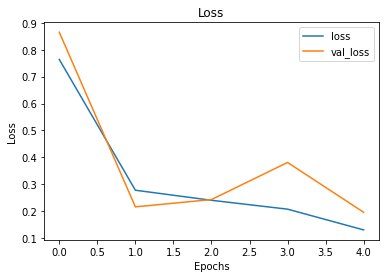

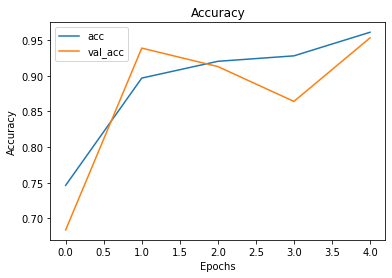

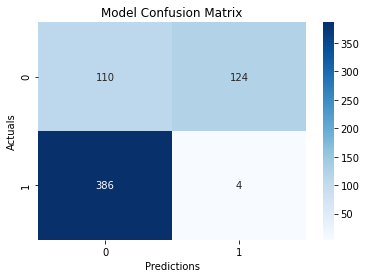

              precision    recall  f1-score   support

           0       0.22      0.47      0.30       234
           1       0.03      0.01      0.02       390

    accuracy                           0.18       624
   macro avg       0.13      0.24      0.16       624
weighted avg       0.10      0.18      0.12       624



20/20 [==============================] - 0s 12ms/step - loss: 0.4399 - acc: 0.8173
Test Loss: 0.43988004326820374
Test Acc: 0.817307710647583


In [130]:
evaluate_results(results_6)

**Best Model**

In the case of diagnosing pneumonia, we want to reduce the number of False Negatives. It is better to falsely label someone as having pneumonia (False Positive), than misclassifying someone who is actually sick who will then go untreated (False Negative). However, we would not want too many false positives either. In this use-case, even with the model's prediction, the x-ray will be verified before making a final diagnosis. Therefore, we want want the overall accuracy of the model to be high to make this process the most efficient for the technician or doctor reviewing the x-ray. The more accurate the model, the less time they need to spend in review.


**Conclusion**

When we look at all the models, model 5 has the best accuracy (81% test accuracy), and less False Negatives than most of the other models.

. This means that there were some instances when the patient had pneumonia but was diagnosed as healthy. It was helpful to grayscale and limit the epochs by using early stopping to prevent overfitting of the model. I believe that our model could have been improved by creating more consistent dataset splits and already having a more balanced dataset with more normal images and more images in our valadation set. 






**Recomendations**

It is important to consider that there may be a potential for human error as well, which would be seen as a misdiagnosis. Work with cross-validating with a team of radiologist and/or pulmonologist would be helpful in making sure that our images where labeled correctly.

Future work would benefit from utilizing more data from populations such as adults and the elderly as well as from different parts of the world. This would allow us to generalize the data and increase the accuracy of diagnosis.

This model may be helpful as a primary screening test for patients. Since it has usable accuracy, this could flag a physician to examine the models determination and make the final confirmatory call on the diagnosis. 

**Future Work**

* Retrain the model using smaller images (ex. 64x64 px or 32x32 px)

* Look at more preprocessing methods to remove the diaphragm and thus remove noise

* Do more research on other methods to tune cnns specifically with chest x-ray/pneumonia classification

